# Homework Set 6

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.optimize import linprog
import scipy.optimize as opt
import yfinance as yf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from tabulate import tabulate
import random

**Unless explicitly forbidden, you can use any standard python function from `numpy`/`scipy`/`pandas`/`matplotlib` or the lectures to solve homework problems. DO NOT use other packages like `Quantlib`/`Quandl`/`portfoliolab`/`etc`.**

## Problem 1 (50 points):

In a previous assignment, you used the current components of the DJIA to compute and test several items in which your optimal portfolio should have been long only. Using the current components of the DJIA:
1.	Starting in July 2020 and using a 6-month lookback compute an optimal portfolio with no riskless asset and without short sale constraints each month until the end of 2021. Use a 6-month lookback to compute the variance-covariance matrix and the means of each of the stocks – assume that the historical values are the true values. You should be using daily returns to compute an optimal portfolio for each month. Plot the expected return, the expected risk, and the ratio of the two for each month (3 plots). Plot the percent holdings for each stock over the six months in a stacked percentage area chart (one plot).
2.	Using the data for the December 2021 portfolio, re-optimize the portfolio without shorting. You should hold a minimum of 2% of the portfolio in cash (which has zero volatility, zero covariance, and zero return). Further, constrain the portfolio so no stock is more than 10% of the portfolio and no stock is less than the cash holding (that does not mean that the appropriate constraint is all stocks are at least 2% -- you will find that does not work). Produce a table of the percentage holdings in each asset and display the mean and standard deviation of the portfolio.
3.	Using the portfolio holdings from the optimal portfolio above, what would the realized returns and standard deviation have been in January and February of 2022? Contrast these values with the values from December 2021. (**Hint**: Do not just say this was x and that was y – provide thoughtful discussion/analysis – explain why they are the same or why they are different.)


In [2]:
#1 download data 
dow_ticker = pd.read_excel(r'/Users/shengbo/Desktop/dow_jones_component.xlsx', header = 1)
tickers_list=list(dow_ticker['Symbol'])
tickers_wt = list(dow_ticker['Index weighting'])
jul_ = date(2020,7,1)
end = [jul_ + relativedelta(months=i) for i in range(18)]
price = yf.download(tickers_list, date(2020,1,1), date(2022,1,1))["Adj Close"]


[*********************100%***********************]  30 of 30 completed


In [3]:
dow_ticker.head()

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,0.0338
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,0.0329
2,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,0.0401
3,Caterpillar,NYSE,CAT,Construction and Mining,1991-05-06,NaN,0.0373
4,Chevron,NYSE,CVX,Petroleum industry,2008-02-19,Also 1930-07-18 to 1999-11-01,0.0207


In [4]:
length = 30
w0 = np.array([1/length]*length)
cons = ({'type': 'eq',
         'fun' : lambda x: 1 - sum(x)})

In [5]:

def optimal_port(p, months, end):
    colname_ = np.arange(len(end))
    df_wt = pd.DataFrame(columns=colname_)
    df_rt = pd.DataFrame(columns=colname_)
    df_risk = pd.DataFrame(columns=colname_)
    cov_list = []

    for j in range(len(end)):
        start =  end[j] + relativedelta(months=-6)
        price = p[start:end[j]]
        day_rt = np.log(price.pct_change().iloc[1:,] + 1 )
        anl_drt = np.exp(day_rt.mean()) ** 252 - 1
        # return
        cov_list.append(day_rt.cov()) #cov
        
        df_rt[j] = anl_drt
        df_risk[j] = day_rt.std()
        # need to calculate excess return but not given benchmark
        cv = day_rt.cov()
        cvi = np.linalg.inv(cv)
        w_opt = cvi.dot(anl_drt.T)/anl_drt.T.dot(cvi).dot(anl_drt)
        w_opt = w_opt/np.sum(w_opt)
        df_wt[j] = w_opt

    return df_wt, df_rt, df_risk, cov_list

In [6]:

wt, rt, risk, cov_ = optimal_port(price, 6, end)

Text(0.5, 1.0, 'ratio of return and risk')

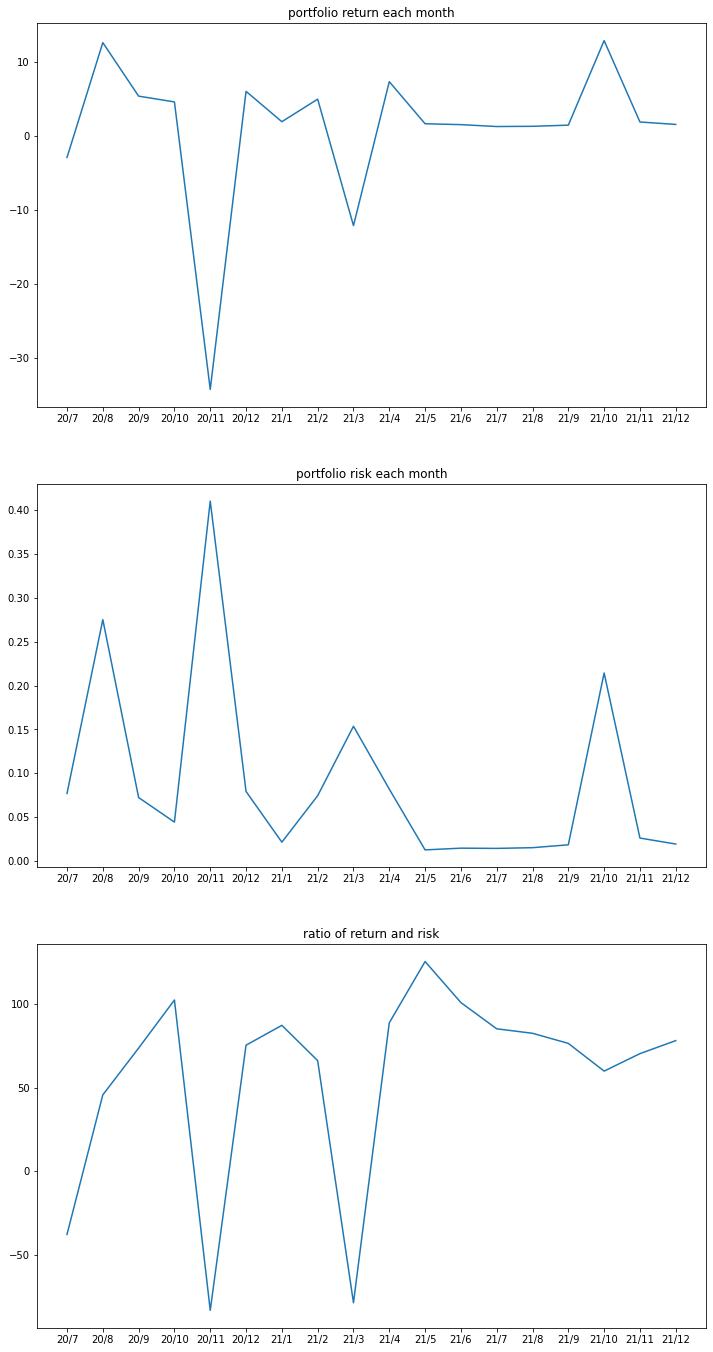

In [7]:
# generate plot for the expected return, the expected risk, and the ratio of the two for each month

port_rt = [np.array(wt.iloc[:,i]).T @ np.array(rt.iloc[:,i]) / 2 for i in range(18)]
port_risk = np.sqrt([np.abs(np.array(wt.iloc[:,i]).T @ cov_[i] @ np.array(wt.iloc[:,i])) for i in range(18)])
months = np.concatenate((['20/'+ str(i) for i in range(7,13)], ['21/' + str(i) for i in range(1,13)]) , axis=0)

plt.figure(figsize=(12,24))
plt.subplot(3,1,1)
plt.plot(months, port_rt)
plt.title('portfolio return each month')
plt.subplot(3,1,2)
plt.plot(months, port_risk)
plt.title('portfolio risk each month')
plt.subplot(3,1,3)
plt.plot(months, port_rt / port_risk )
plt.title('ratio of return and risk')

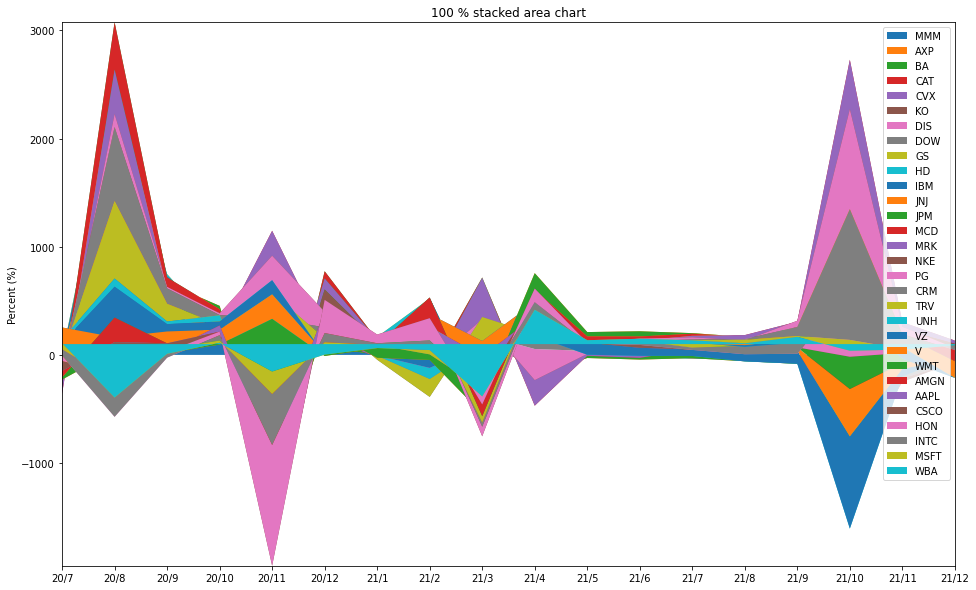

In [8]:
# percent holdings
import numpy as np
from matplotlib import pyplot as plt

fnx = lambda : np.random.randint(5, 50, 10)
y = wt
x = months

# Make new array consisting of fractions of column-totals,
# using .astype(float) to avoid integer division
percent = y  * 100 

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)


ax.stackplot(x, percent)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
ax.legend(tickers_list)
#ax.set_ylim([-2000, 2000])
plt.show()

Question 2 is an optimization problem: our goal is to minimize volatility of the portfolio, with constrain w^T@r = 1, 1 - sum(wi) >= 0.02 and each 0.1 >= wi >= 1 - sum(wi). It's not easy to do optimization with changing sum(wi), set it to a fixed value do optimization with function  

In [9]:
#2 
rt_21dec = wt.iloc[:,-1]
cov_21dec = cov_[-1]

In [48]:
# min var, fixed w^T@r, wi in a range

def objective(w, sign=1.0):
    return w[:-1].T @ cov_21dec @ w[:-1] * 100 

def derivative(w, sign=1.0):
    return 2 * cov_21dec @ w * 100 


In [1]:
w0 = np.ones(30) * 0.0325
cons = (
        {'type': 'eq', 'fun': lambda w:  w.T @ rt_21dec - w0.T @ rt_21dec},
        {'type': 'ineq', 'fun': lambda w: 0.98 - sum(w)},
        {'type': 'ineq', 'fun': lambda w: 0.1 * np.ones(30) - w},
        {'type': 'ineq', 'fun': lambda w: w - 1 + sum(w)},
        {'type': 'ineq', 'fun': lambda w: w}) #make sure all long) 

result = opt.minimize(objective, w0, args=(1.0,), jac=derivative,
                      constraints=cons, method='SLSQP', options={'disp': True})

NameError: name 'np' is not defined

In [50]:
# include the cash part and arrange it at the last
w0 = np.ones(31) /31
# cons = (
#         {'type': 'eq', 'fun': lambda w:  w[:-1].T @ rt_21dec - w0[:-1].T @ rt_21dec},
#         {'type': 'ineq', 'fun': lambda w: w[-1] - 0.2},
#         {'type': 'ineq', 'fun': lambda w: 0.1 * np.ones(30) - w[:-1]},
#         {'type': 'ineq', 'fun': lambda w: w[:-1] - w[-1]},
#         {'type': 'ineq', 'fun': lambda w: w}) #make sure all long

rrr = opt.minimize(objective, w0, args=(1.0,), 
#                       constraints=cons, 
                   method='SLSQP', options={'disp': True})

ValueError: Dot product shape mismatch, (30, 30) vs (31,)

In [12]:
result.x

array([0.02      , 0.02      , 0.02      , 0.02      , 0.02      ,
       0.02184145, 0.02      , 0.02      , 0.02      , 0.02      ,
       0.02      , 0.03590838, 0.02      , 0.02      , 0.02      ,
       0.1       , 0.02      , 0.07654829, 0.02818178, 0.02      ,
       0.03400161, 0.02      , 0.02008349, 0.08625273, 0.02      ,
       0.02      , 0.02      , 0.1       , 0.02      , 0.07718226])

In [ ]:
wt_b = result.x/sum(result.x)
col1 = tickers_list.copy()
col1.append('cash')
col2= wt_b
data_b = zip(col1 ,col2)
col_names = ["Component", "Weight"]
print(tabulate(data_b, headers=col_names, tablefmt="fancy_grid"))

In [13]:
wt_b = result.x/sum(result.x)
col1 = tickers_list.copy()
col1.append('cash')
col2=np.append(wt_b, 1-sum(wt_b))
data_b = zip(col1 ,col2)
col_names = ["Component", "Weight"]
print(tabulate(data_b, headers=col_names, tablefmt="fancy_grid"))

╒═════════════╤═══════════╕
│ Component   │    Weight │
╞═════════════╪═══════════╡
│ MMM         │ 0.02      │
├─────────────┼───────────┤
│ AXP         │ 0.02      │
├─────────────┼───────────┤
│ BA          │ 0.02      │
├─────────────┼───────────┤
│ CAT         │ 0.02      │
├─────────────┼───────────┤
│ CVX         │ 0.02      │
├─────────────┼───────────┤
│ KO          │ 0.0218414 │
├─────────────┼───────────┤
│ DIS         │ 0.02      │
├─────────────┼───────────┤
│ DOW         │ 0.02      │
├─────────────┼───────────┤
│ GS          │ 0.02      │
├─────────────┼───────────┤
│ HD          │ 0.02      │
├─────────────┼───────────┤
│ IBM         │ 0.02      │
├─────────────┼───────────┤
│ JNJ         │ 0.0359084 │
├─────────────┼───────────┤
│ JPM         │ 0.02      │
├─────────────┼───────────┤
│ MCD         │ 0.02      │
├─────────────┼───────────┤
│ MRK         │ 0.02      │
├─────────────┼───────────┤
│ NKE         │ 0.1       │
├─────────────┼───────────┤
│ PG          │ 0.02

In [14]:
ppp = yf.download(tickers_list, date(2021,12,1), date(2021,12,31))["Adj Close"]

[*********************100%***********************]  30 of 30 completed


In [15]:
print('the mean of the portfolio during 2021 December is', np.mean(ppp@wt_b))
print('the standard deviation of the portfolio during 2021 December is', np.std(ppp@wt_b))

the mean of the portfolio during 2021 December is 156.39911711580416
the standard deviation of the portfolio during 2021 December is 2.8320209571585333


In [16]:
#3
ppp1 = yf.download(tickers_list, date(2022,1,1), date(2022,2,1)-relativedelta(days=1))["Adj Close"]
ppp2 = yf.download(tickers_list, date(2022,2,1), date(2022,3,1)-relativedelta(days=1))["Adj Close"]


[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  30 of 30 completed


In [17]:

print('the mean of the portfolio during 2022 Jan is', np.mean(ppp1@wt_b))
print('the standard deviation of the portfolio during 2022 Jan is', np.std(ppp1@wt_b))

print('the mean of the portfolio during 2022 Feb is', np.mean(ppp2@wt_b))
print('the standard deviation of the portfolio during 2022 Feb is', np.std(ppp2@wt_b))

the mean of the portfolio during 2022 Jan is 156.59416114491844
the standard deviation of the portfolio during 2022 Jan is 3.4792494511755105
the mean of the portfolio during 2022 Feb is 153.36554564639061
the standard deviation of the portfolio during 2022 Feb is 3.1088396432567933


The mean portfolio value remain the same in 2022 Jan and then fell down at 2022 Feb , which suggest a decreasing in the portfolio. One possible explanation is that recent politic events affect the global economy and all components in the market was influenced.

After increase to 3.4 in Jan, the standard deviation keep above 3 at Feburary. One possible reason is after the events rises chaos in Jan, the industries where companies in the dow_jones list were still affected and their stock prices were still unstable.

## Problem 2 (50 points):

Often portfolios are constructed where they are intended to “track” another portfolio or index. On the buy side, this can be for performance purposes – the portfolio manager may be held to some index with no more than 5% tracking error. On the sell side it can be for index replication – it is cheaper to hold a smaller number of shares than to replicate the index exactly. Typically, tracking error is measured by:
$$
\text{TE} (w) = [{\text{Var}(w^T x-y)}]^{\frac{1}{2}}
$$

where $y$ is the benchmark return, $x$ is the vector os asset returns, and $w$ is the vector or weights. One way to specify the objective function is:

$$
w^* = \min_w \text{TE}(w)
$$

with

$$
\sum_{i=1}^n w_i = 1
$$

Assume that you would like to construct a tracking portfolio for the DJIA that consists of a maximum of 10 stocks (all long). You could, of course, try all 10 stock combinations of the 30 stocks in the DJIA – that would be over 30 million optimizations – so if you could run one optimization a minute, twenty-four hours a day, seven days a week, it would take more than 57 years!
1.	First, try randomly selecting 10 stocks from the DJIA and find the minimum tracking error with the index. Use the December data with all the assumptions above.
2.	Now compute the tracking error for 10 more randomly selected sets of 10 stocks – plot the tracking errors.
3.	Can you think of a way to solve this problem – limiting the portfolio to 10 stocks but finding the best portfolio with the minimum tracking error. No quantum computers, no parallel processing – rather a direct way to simplify/modify the problem. Describe your process in detail.



In [18]:
#1
dow12_price = ppp @ tickers_wt 
dow12_rt = dow12_price.pct_change()[1:]
ppp_rt = ppp.pct_change().iloc[1:]
random.seed(2323)
comp_idx = random.sample(range(30),10)
comp_rt = ppp_rt.iloc[:,comp_idx]

In [19]:
def obj2(w, rt):
    diff =  rt @ w - dow12_rt
    return np.sqrt(np.var(diff)) 

In [20]:
w0 = np.ones(10) * 0.1
cons2 = ({'type': 'eq', 'fun': lambda w:  sum(w)-1}) #make sure weight sum = 1   
bnds = [(0, 1)]*10
result2 = opt.minimize(obj2 , w0, args=(comp_rt,), bounds = bnds, constraints=cons2, method='SLSQP')

In [21]:
print(f'the minimum tracking error with these 10 component is {result2.fun*100:.4f}%') 

the minimum tracking error with these 10 component is 0.3539%


In [22]:
#2
random.seed(2323)
inc_idx = random.sample(range(30),20)
error_list=[]
for i in range(9,20):
    temp_idx = inc_idx[:i+1]
    temp_rt = ppp_rt.iloc[:,temp_idx]
    w0_temp = np.ones(i+1) /(i+1)
    cons2 = ({'type': 'eq', 'fun': lambda w:  sum(w)-1}) #make sure all long 
    result2 = opt.minimize(obj2 , w0_temp,\
                           args=(temp_rt,), constraints=cons2, method='SLSQP')
    error_list.append(result2.fun)

Text(0, 0.5, 'the minimum tracking error')

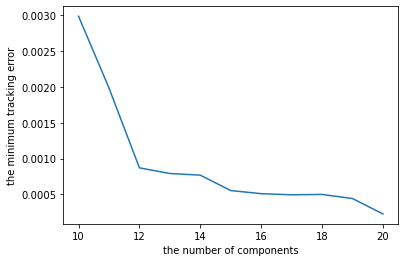

In [23]:
plt.plot(np.arange(10,21),error_list)
plt.xlabel('the number of components')
plt.ylabel('the minimum tracking error')

The idea of question 3 is find 10 features with largest covariance to the portfolio by DJIA and using these features to calculate minimum tracking error 

In [24]:
#3


In [25]:
data_ = np.std(ppp_rt)
Df = pd.DataFrame(data = np.array(data_)
             , columns = ['std'], index=range(30))

In [26]:
mat_ = ppp_rt.copy()
mat_['DJ']=dow12_rt
matt_ = mat_.corr().set_index(np.arange(31)).iloc[:30,]
sig_idx = np.array(matt_.sort_values(by='DJ').iloc[-10:].index)

In [27]:
sig_rt = ppp_rt.iloc[:,sig_idx]

In [28]:
w0 = np.ones(10) * 0.1
cons2 = ({'type': 'eq', 'fun': lambda w:  sum(w)-1}) #make sure all long 
bnds = [(0, 1)]*10
result3 = opt.minimize(obj2 , w0, args=(sig_rt,), bounds = bnds, constraints=cons2, method='SLSQP', options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002073962031851804
            Iterations: 13
            Function evaluations: 144
            Gradient evaluations: 13


In [29]:
print(f'The error after optimization is {result3.fun*100:.4f}%' )

The error after optimization is 0.2074%
